In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
print(os.listdir(r"D:\AMME4111\#Code\NotSeggedCNN"))

['test', 'train']


In [2]:
TRAIN_DIR = r"D:\AMME4111\#Code\NotSeggedCNN\train"
TEST_DIR =  r"D:\AMME4111\#Code\NotSeggedCNN\test"

In [3]:
def assign_num_label(str_label):
    if nextdir in ['mild']:
        label = 0
    elif nextdir in ['moderate']:
        label = 1
    elif nextdir in ['severe']:
        label = 2
    return label

for nextdir in os.listdir(TRAIN_DIR):
    print(nextdir)

mild
moderate
severe


In [4]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        label_word = nextdir
        label_numerical = assign_num_label(label_word)
        temp = Dir + str('\\')+ nextdir 
        #print(temp)
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '\\' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                img = skimage.transform.resize(img, (512, 512, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label_numerical)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [5]:
X_train, y_train = preprocessing_data(TRAIN_DIR)

100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


In [6]:
X_test , y_test = preprocessing_data(TEST_DIR)

100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


In [7]:
print(X_train.shape,'\n',X_test.shape)

(78, 512, 512, 3) 
 (61, 512, 512, 3)


In [8]:
from keras.utils.np_utils import to_categorical

# num_classes=3, one-hot code
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

Using TensorFlow backend.


In [9]:
mild_images = os.listdir(TRAIN_DIR + '\\'+"mild")
moderate_images = os.listdir(TRAIN_DIR + '\\'+ "moderate")
severe_images = os.listdir(TRAIN_DIR + '\\'+ "severe")
print(severe_images)

['009.png', '023.png', '028.png', '035.png', '036.png', '041.png', '049.png', '083.png', '108.png', '131.png', '212.png', '220.png', '270.png']


In [10]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

C:\Users\Yang\Anaconda3\envs\tf_cnn\lib\site-packages\keras\callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [11]:
filepath="transferlearning_weightsAlexnet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [12]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [13]:
a = X_train.shape[0]
b = y_test.shape[0]
print(a,b)
X_train=X_train.reshape(a,3,512,512 )
X_test=X_test.reshape(b,3,512,512)

78 61


In [14]:
from keras.applications.vgg16 import VGG16
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False , input_shape=(3, 512, 512))

In [15]:
x = base_model.output
x = Dropout(0.4)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
predictions = Dense(3, activation='softmax')(x)

In [16]:
#  freeze all our base_model layers and train the last ones
# ref: https://medium.com/abraia/first-steps-with-transfer-learning-for-custom-image-classification-with-keras-b941601fcad5
for layer in base_model.layers:
    layer.trainable = False

In [17]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 512, 512)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 512, 512)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 512, 512)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 256, 256)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 256, 256)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 256, 256)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [18]:
batch_size = 30
epochs = 50

In [19]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 78 samples, validate on 61 samples
Epoch 1/50
78/78 [==============================] - ETA: 10s - loss: 1.3074 - acc: 0.40 - ETA: 1s - loss: 1.2784 - acc: 0.4062 - 16s 210ms/step - loss: 1.2709 - acc: 0.3846 - val_loss: 1.3823 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to transferlearning_weightsAlexnet.hdf5
Epoch 2/50
78/78 [==============================] - ETA: 1s - loss: 1.2085 - acc: 0.406 - ETA: 0s - loss: 1.2160 - acc: 0.343 - 3s 34ms/step - loss: 1.2011 - acc: 0.3846 - val_loss: 0.9734 - val_acc: 0.9344

Epoch 00002: val_acc improved from 0.00000 to 0.93443, saving model to transferlearning_weightsAlexnet.hdf5
Epoch 3/50
78/78 [==============================] - ETA: 0s - loss: 1.1895 - acc: 0.343 - ETA: 0s - loss: 1.1613 - acc: 0.390 - 3s 34ms/step - loss: 1.1427 - acc: 0.3974 - val_loss: 1.0848 - val_acc: 0.2787

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00003: val_acc did not i

78/78 [==============================] - ETA: 0s - loss: 1.0530 - acc: 0.406 - ETA: 0s - loss: 1.0695 - acc: 0.406 - 3s 32ms/step - loss: 1.1002 - acc: 0.3590 - val_loss: 0.9000 - val_acc: 0.9344

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000001181490946e-25.

Epoch 00025: val_acc did not improve from 0.95082
Epoch 26/50
78/78 [==============================] - ETA: 0s - loss: 1.0932 - acc: 0.500 - ETA: 0s - loss: 1.0939 - acc: 0.484 - 3s 33ms/step - loss: 1.0919 - acc: 0.4615 - val_loss: 0.9022 - val_acc: 0.9344

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000001428009978e-26.

Epoch 00026: val_acc did not improve from 0.95082
Epoch 27/50
78/78 [==============================] - ETA: 0s - loss: 1.1165 - acc: 0.437 - ETA: 0s - loss: 1.1332 - acc: 0.437 - 2s 32ms/step - loss: 1.1311 - acc: 0.4615 - val_loss: 0.9052 - val_acc: 0.9344

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.000000142800998e-27.

Epoch 00027: val_acc did not improve fro


Epoch 00049: val_acc did not improve from 0.95082
Epoch 50/50
78/78 [==============================] - ETA: 0s - loss: 1.0592 - acc: 0.500 - ETA: 0s - loss: 1.0689 - acc: 0.468 - 3s 32ms/step - loss: 1.0858 - acc: 0.4872 - val_loss: 0.8925 - val_acc: 0.9508

Epoch 00050: val_acc did not improve from 0.95082


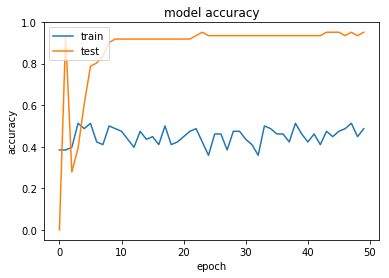

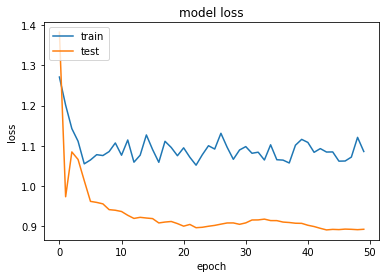

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()